In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression

In [2]:
class predictor:
    def __init__(self, stock, reference = '^GSPC'):
        self.stock = yf.Ticker(stock)
        self.reference = yf.Ticker(reference)
        if 'quoteType' not in self.stock.info or self.stock.info['quoteType'] != 'EQUITY' :
            raise ValueError('Invalid Stock Symbol')
        if 'quoteType' not in self.reference.info or self.reference.info['quoteType'] != 'INDEX':
            raise ValueError('Invalid Stock Reference')
    
    def _getResuls(self, returns, ant, adj, window, date_e):
        results = {'Statistics' : ['stdev_all'], 'MAR' : [np.std(returns.iloc[0: window, 5])], 'MKAR': [np.std(returns.iloc[0: window, 6])], 'RAR': [np.std(returns.iloc[0: window, 7])]}
        results = pd.DataFrame.from_dict(results).set_index('Statistics')
        results.loc['stdev_ant'] = results.apply(lambda x: x["stdev_all"] * (ant ** 0.5))
        results.loc['stdev_adj'] = results.apply(lambda x: x["stdev_all"] * (adj ** 0.5))
        results.loc['stdev_per'] = results.apply(lambda x: x["stdev_all"] * ((ant + adj + 1) ** 0.5))
        results.loc['CAR_e'] = returns.loc[returns['Date'] == date_e, 'MAR' : 'RAR'].values.tolist()[0]
        results.loc['CAR_ant'] = returns.iloc[window : window + ant, 5 : 8].sum(axis = 0)
        results.loc['CAR_adj'] = returns.iloc[window + ant + 1 : window + ant + adj, 5 : 8].sum(axis = 0)
        results.loc['CAR_total'] = returns.iloc[window : window + ant + adj, 5 : 8].sum(axis = 0)
        results.loc['BHAR_e'] = returns.iloc[window + ant, 5 : 8]
        results.loc['BHAR_ant'] = (np.prod((returns.iloc[window : window + ant, 5 : 8] + 1).to_numpy(), axis = 0) - 1)
        results.loc['BHAR_adj'] = (np.prod((returns.iloc[window + ant + 1 : window + ant + adj, 5 : 8] + 1).to_numpy(), axis = 0) - 1)
        results.loc['BHAR_total'] = (np.prod((returns.iloc[window : window + ant + adj, 5 : 8] + 1).to_numpy(), axis = 0) - 1)
        results.loc['t_CAR_e'] = results.loc['CAR_e'] / results.loc['stdev_all']
        results.loc['t_CAR_ant'] = results.loc['CAR_ant'] / results.loc['stdev_ant']
        results.loc['t_CAR_adj'] = results.loc['CAR_adj'] / results.loc['stdev_adj']
        results.loc['t_CAR_total'] = results.loc['CAR_total'] / results.loc['stdev_per']
        results.loc['t_BHAR_e'] = results.loc['BHAR_e'] / results.loc['stdev_all']
        results.loc['t_BHAR_ant'] = results.loc['BHAR_ant'] / results.loc['stdev_ant']
        results.loc['t_BHAR_adj'] = results.loc['BHAR_adj'] / results.loc['stdev_adj']
        results.loc['t_BHAR_total'] = results.loc['BHAR_total'] / results.loc['stdev_per']
        results.loc['p_CAR_e', 'MAR' : 'MKAR'] = stats.t.sf(abs(results.loc['t_CAR_e', 'MAR' : 'MKAR']), df= window - 1)*2
        results.loc['p_CAR_e', 'RAR'] = stats.t.sf(abs(results.loc['t_CAR_e', 'RAR']), df= window - 2)*2
        results.loc['p_CAR_ant', 'MAR' : 'MKAR'] = stats.t.sf(abs(results.loc['t_CAR_ant', 'MAR' : 'MKAR']), df= window - 1)*2
        results.loc['p_CAR_ant', 'RAR'] = stats.t.sf(abs(results.loc['t_CAR_ant', 'RAR']), df= window - 2)*2
        results.loc['p_CAR_adj', 'MAR' : 'MKAR'] = stats.t.sf(abs(results.loc['t_CAR_adj', 'MAR' : 'MKAR']), df= window - 1)*2
        results.loc['p_CAR_adj', 'RAR'] = stats.t.sf(abs(results.loc['t_CAR_adj', 'RAR']), df= window - 2)*2
        results.loc['p_CAR_total', 'MAR' : 'MKAR'] = stats.t.sf(abs(results.loc['t_CAR_total', 'MAR' : 'MKAR']), df= window - 1)*2
        results.loc['p_CAR_total', 'RAR'] = stats.t.sf(abs(results.loc['t_CAR_total', 'RAR']), df= window - 2)*2

        results.loc['p_BHAR_e', 'MAR' : 'MKAR'] = stats.t.sf(abs(results.loc['t_BHAR_e', 'MAR' : 'MKAR']), df= window - 1)*2
        results.loc['p_BHAR_e', 'RAR'] = stats.t.sf(abs(results.loc['t_BHAR_e', 'RAR']), df= window - 2)*2
        results.loc['p_BHAR_ant', 'MAR' : 'MKAR'] = stats.t.sf(abs(results.loc['t_BHAR_ant', 'MAR' : 'MKAR']), df= window - 1)*2
        results.loc['p_BHAR_ant', 'RAR'] = stats.t.sf(abs(results.loc['t_BHAR_ant', 'RAR']), df= window - 2)*2
        results.loc['p_BHAR_adj', 'MAR' : 'MKAR'] = stats.t.sf(abs(results.loc['t_BHAR_adj', 'MAR' : 'MKAR']), df= window - 1)*2
        results.loc['p_BHAR_adj', 'RAR'] = stats.t.sf(abs(results.loc['t_BHAR_adj', 'RAR']), df= window - 2)*2
        results.loc['p_BHAR_total', 'MAR' : 'MKAR'] = stats.t.sf(abs(results.loc['t_BHAR_total', 'MAR' : 'MKAR']), df= window - 1)*2
        results.loc['p_BHAR_total', 'RAR'] = stats.t.sf(abs(results.loc['t_BHAR_total', 'RAR']), df= window - 2)*2
        return results
    
    def fit(self, ant, adj, window, date_e):
        hist_s = self.stock.history(period = 'max')
        hist_r = self.reference.history(period = 'max')
        df = pd.merge(hist_s, hist_r, left_on = hist_s.index, right_on = hist_r.index)
        if ant > 15 or ant < 5:
            ant = 10
        if adj > 15 or adj < 5:
            adj = 10
        if window > 90 or window < 30:
            window = 45
        try:
            date_e = pd.to_datetime(date_e)
        except:
            raise ValueError('Ivalid Date')
        if date_e not in df.key_0.values:
            raise ValueError('Ivalid Date')
        index = df[df.key_0 == date_e].index[0]
        max_index = df.index.max()
        if not ((window + ant + 1) < index < max_index - (adj + 15)):
            raise ValueError('The date is not relevant')
        index = df[df.key_0 == date_e].index[0]
        returns = df[(df.index >= index - (window + ant + 1)) & (df.index <= index + adj + 15 )][['key_0', 'Close_x', 'Close_y']]
        returns.columns = ['Date', 'Close_s', 'Close_r']
        returns['return_s'] = ((returns['Close_s'] / returns['Close_s'].shift(1)) - 1)
        returns['return_r'] = ((returns['Close_r'] / returns['Close_r'].shift(1)) - 1)
        returns.dropna(inplace = True)
        returns['MAR'] = returns['return_s'] - returns.iloc[0 : window, 4].mean()
        returns['MKAR'] = returns['return_s'] - returns['return_r']
        model = LinearRegression().fit(returns[['return_r']], returns['return_s'])
        self.alpha = model.intercept_
        self.beta = model.coef_[0]
        returns['RAR'] = returns['return_s'] - (self.alpha + self.beta * returns['return_r'])
        return returns, self._getResuls(returns, ant, adj, window, date_e)

In [3]:
p = predictor(input('Enter Symbol of the Stock \n') , input('Enter Symbol of the Index \n'))

Enter Symbol of the Stock 
AAPL
Enter Symbol of the Index 
^GSPC


In [5]:
returns, results = p.fit(int(input('Enter Anticipation period in days \n')) , int(input('Enter Adjustment period in days \n')) , int(input('Enter Estimation window in days \n')) , pd.to_datetime(input("Enter the event date with this format : YYYY/MM/DD \n")))

Enter Anticipation period in days 
15
Enter Adjustment period in days 
22
Enter Estimation window in days 
31
Enter the event date with this format : YYYY/MM/DD 
2018/10/10


<AxesSubplot:xlabel='Date'>

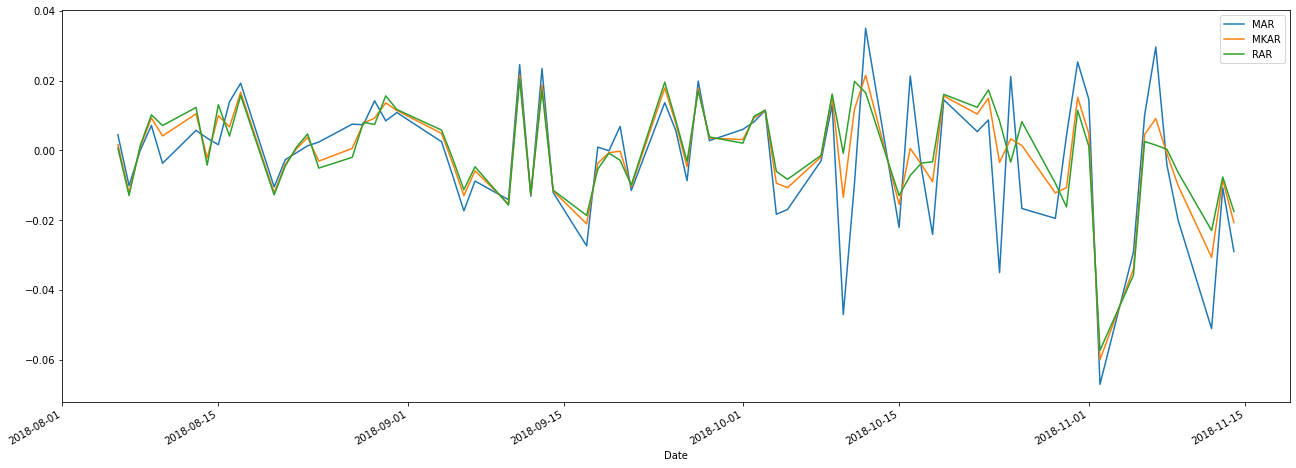

In [6]:
returns.plot(x="Date", y=["MAR", "MKAR", "RAR"], kind="line", figsize=(22, 8))

In [7]:
results*100

,MAR,MKAR,RAR
Statistics,,,
stdev_all,1.170785,1.056611,1.054150
stdev_ant,4.534430,4.092236,4.082706
stdev_adj,3.702346,3.341297,3.333515
stdev_per,5.969854,5.387679,5.375132
CAR_e,-4.705340,-1.346183,-0.083321
CAR_ant,2.885024,4.794323,5.588867
CAR_adj,2.406838,4.620776,5.497456
CAR_total,0.586521,8.068916,11.003002
BHAR_e,-4.705340,-1.346183,-0.083321
